![deelema](../img/DeeLeMa.png)

## Import Packages

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.distributions import Uniform
from torch.optim.lr_scheduler import OneCycleLR, PolynomialLR, CosineAnnealingLR

import lightning as pl
from lightning import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import matplotlib.colors as colors

from torchinfo import summary

import warnings
warnings.filterwarnings('ignore')

PATH_DATASETS = "."
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 2048 if AVAIL_GPUS else 64
# BATCH_SIZE=1

plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

In [2]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
class ToyData(Dataset):
    def __init__(self, p_A, p_a, p_B, p_b, q_C, q_c):
        self.X = torch.column_stack([p_A, p_a, p_B, p_b])
        self.q_C = q_C
        self.q_c = q_c
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.q_C[idx], self.q_c[idx]

## Data Loading

In [5]:
DATA_PATH = "../data/"
PROCESS   = "toy"
np_data   = np.load(DATA_PATH + PROCESS + '_array_new.npz')

In [6]:
pa1 = np_data['b1']
pa2 = np_data['b2']
pb1 = np_data['l2']
pb2 = np_data['l1']
qc1 = np_data['nu1']
qc2 = np_data['nu2']

In [7]:
def np_mass_sq(p):
    return p[:,0]**2 - p[:,1]**2 - p[:,2]**2 - p[:,3]**2

g = np.array([1,-1,-1,-1])
def Mass(p, ax=1):
    return torch.sqrt(p[:,0]**2 - p[:,1]**2 - p[:,2]**2 - p[:,3]**2)

def npMass(p, ax=1):
    return np.sqrt(p[:,0]**2 - p[:,1]**2 - p[:,2]**2 - p[:,3]**2)

In [8]:
pa1.shape, pb2.shape

((1080000, 4), (1080000, 4))

## Into PyTorch

In [9]:
np_momenta = [pa1, pa2, pb1, pb2, qc1, qc2]

X = np.concatenate((pa1,pa2,pb1,pb2,qc1,qc2), axis=1)

scaler = 1000
torch_momenta = list(map(lambda x: torch.tensor(x/scaler, dtype=torch.float32), np.array_split(X, 6, axis=1)))

## Network

In [10]:
class DeeLeMa(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        
        hidden_layer       = hparams["hidden_layer"]
        hidden_depth       = hparams["hidden_depth"]
        learning_rate      = hparams["learning_rate"]
        batch_size         = hparams["batch_size"]
        
        self.hidden_layer  = hidden_layer
        self.hidden_depth  = hidden_depth
        self.learning_rate = learning_rate
        # self.max_lr        = hparams['max_lr']
        self.batch_size    = batch_size
        self.epochs        = hparams["epochs"]
        self.learn_mode    = hparams['learn_mode']   # for pT mC loss on off
        self.squared_mass  = hparams['squared_mass'] # True or False
        self.dist_fn       = hparams['dist_fn']      # l1 or l2

        m_C = torch.tensor(hparams["m_C_init"])
        m_B_add = torch.tensor(hparams["m_B_add"])
        m_A_add = torch.tensor(hparams["m_A_add"])

        m_B = m_C + m_B_add
        m_A = m_B + m_A_add

        if self.squared_mass == True:
            m_C = m_C ** 2
            m_B = m_B ** 2
            m_A = m_A ** 2
        
        self.m_C = m_C
        self.m_B_add = nn.Parameter(m_B_add, requires_grad=True)
        self.m_A_add = nn.Parameter(m_A_add, requires_grad=True)
        self.m_B = self.m_C + F.gelu(self.m_B_add, approximate='tanh')
        self.m_A = self.m_B + F.gelu(self.m_A_add, approximate='tanh')
        
        layers = [nn.Linear(16, hidden_layer), nn.GELU(approximate='tanh')]
        for i in range(hidden_depth):
            layers.extend([
                nn.Linear(hidden_layer, hidden_layer),
                nn.GELU(approximate='tanh'),
        ])

        if self.learn_mode == 'pt_mc':
            layers.append(nn.Linear(hidden_layer, 8))
        elif self.learn_mode in ['pt', 'mc']:
            layers.append(nn.Linear(hidden_layer, 6))
        elif self.learn_mode == None:
            layers.append(nn.Linear(hidden_layer, 4))
                
        self.net = nn.Sequential(*layers)
        
        self.save_hyperparameters(hparams)
        
        self.ds = None

    def compute_mass(self):
        self.m_B = self.m_C + F.gelu(self.m_B_add, approximate='tanh')
        self.m_A = self.m_B + F.gelu(self.m_A_add, approximate='tanh')
        
    def forward(self, x):
        return self.net(x)
        
    def training_step(self, batch, batch_idx):
        x, _, _ = batch
        pa1 = x[:,0:4]
        pa2 = x[:,4:8]
        pb1 = x[:,8:12]
        pb2 = x[:,12:16]
        
        q = self(x)
        if self.learn_mode == 'pt_mc':
            qc1 = q[:,0:4]
            qc2 = q[:,4:8]
        elif self.learn_mode == 'pt':
            qx1 = q[:,0:1] 
            qy1 = q[:,1:2]
            qx2 = q[:,2:3] 
            qy2 = q[:,3:4]
            qz1 = q[:,4:5]   
            qz2 = q[:,5:6]          
            
            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)    
            
            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1) 
            
        elif self.learn_mode == 'mc':
            qx1 = q[:,0:1] 
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]   
            qz2 = q[:,3:4]
            Eq1 = q[:,4:5]
            Eq2 = q[:,5:6]            

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)    
            
        elif self.learn_mode == None:
            qx1 = q[:,0:1] 
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]   
            qz2 = q[:,3:4]

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)        
        
        pB1 = pb1 + qc1
        pB2 = pb2 + qc2
        pA1 = pa1 + pB1
        pA2 = pa2 + pB2
        pT = (pA1 + pA2)[:,1:3]

        if self.squared_mass == True:
            mC1_sq = np_mass_sq(qc1)
            mC2_sq = np_mass_sq(qc2)
            mB1_sq = np_mass_sq(pB1)
            mB2_sq = np_mass_sq(pB2)
            mA1_sq = np_mass_sq(pA1)
            mA2_sq = np_mass_sq(pA2)
        else:
            mC1_sq = Mass(qc1)
            mC2_sq = Mass(qc2)
            mB1_sq = Mass(pB1)
            mB2_sq = Mass(pB2)
            mA1_sq = Mass(pA1)
            mA2_sq = Mass(pA2)

        self.compute_mass()

        mCs = self.m_C * torch.ones_like(mC1_sq)
        mBs = self.m_B * torch.ones_like(mB1_sq)
        mAs = self.m_A * torch.ones_like(mA1_sq)

        if self.dist_fn == "l1":
            loss_C = torch.abs(mC1_sq - mC2_sq) + torch.abs(mC1_sq - mCs) + torch.abs(mC2_sq - mCs)
            loss_B = torch.abs(mB1_sq - mB2_sq) + torch.abs(mB1_sq - mBs) + torch.abs(mB2_sq - mBs)
            loss_A = torch.abs(mA1_sq - mA2_sq) + torch.abs(mA1_sq - mAs) + torch.abs(mA2_sq - mAs)
        elif self.dist_fn == "l2":
            loss_C = torch.square(mC1_sq - mC2_sq) + torch.square(mC1_sq - mCs) + torch.square(mC2_sq - mCs)
            loss_B = torch.square(mB1_sq - mB2_sq) + torch.square(mB1_sq - mBs) + torch.square(mB2_sq - mBs)
            loss_A = torch.square(mA1_sq - mA2_sq) + torch.square(mA1_sq - mAs) + torch.square(mA2_sq - mAs)
        
        loss_pT = pT[:,0]**2 + pT[:,1]**2            
        
        loss_C = loss_C 
        loss_B = loss_B 
        loss_A = loss_A
        
        if self.learn_mode == 'pt_mc':
            loss = (loss_A + loss_B + loss_C).mean() + loss_pT.mean()
        elif self.learn_mode == 'pt':
            loss = (loss_A + loss_B).mean() + loss_pT.mean()
        elif self.learn_mode == 'mc':
            loss = (loss_A + loss_B + loss_C).mean() 
        elif self.learn_mode == None:        
            loss = (loss_A + loss_B).mean() 
                
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _, _ = batch
        pa1 = x[:,0:4]
        pa2 = x[:,4:8]
        pb1 = x[:,8:12]
        pb2 = x[:,12:16]
        
        q = self(x)
        if self.learn_mode == 'pt_mc':
            qc1 = q[:,0:4]
            qc2 = q[:,4:8]
        elif self.learn_mode == 'pt':
            qx1 = q[:,0:1] 
            qy1 = q[:,1:2]
            qx2 = q[:,2:3]
            qy2 = q[:,3:4]
            qz1 = q[:,4:5]
            qz2 = q[:,5:6]
            
            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)
            
            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)
            
        elif self.learn_mode == 'mc':
            qx1 = q[:,0:1]
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]
            qz2 = q[:,3:4]
            Eq1 = q[:,4:5]
            Eq2 = q[:,5:6]

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)
            
        elif self.learn_mode == None:
            qx1 = q[:,0:1]
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]
            qz2 = q[:,3:4]

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)
        
        pB1 = pb1 + qc1
        pB2 = pb2 + qc2
        pA1 = pa1 + pB1
        pA2 = pa2 + pB2
        pT = (pA1 + pA2)[:,1:3]

        if self.squared_mass == True:
            mC1_sq = np_mass_sq(qc1)
            mC2_sq = np_mass_sq(qc2)
            mB1_sq = np_mass_sq(pB1)
            mB2_sq = np_mass_sq(pB2)
            mA1_sq = np_mass_sq(pA1)
            mA2_sq = np_mass_sq(pA2)
        else:
            mC1_sq = Mass(qc1)
            mC2_sq = Mass(qc2)
            mB1_sq = Mass(pB1)
            mB2_sq = Mass(pB2)
            mA1_sq = Mass(pA1)
            mA2_sq = Mass(pA2)

        self.compute_mass()

        mCs = self.m_C * torch.ones_like(mC1_sq)
        mBs = self.m_B * torch.ones_like(mB1_sq)
        mAs = self.m_A * torch.ones_like(mA1_sq)
        
        if self.dist_fn == "l1":
            loss_C = torch.abs(mC1_sq - mC2_sq) + torch.abs(mC1_sq - mCs) + torch.abs(mC2_sq - mCs)
            loss_B = torch.abs(mB1_sq - mB2_sq) + torch.abs(mB1_sq - mBs) + torch.abs(mB2_sq - mBs)
            loss_A = torch.abs(mA1_sq - mA2_sq) + torch.abs(mA1_sq - mAs) + torch.abs(mA2_sq - mAs)
        elif self.dist_fn == "l2":
            loss_C = torch.square(mC1_sq - mC2_sq) + torch.square(mC1_sq - mCs) + torch.square(mC2_sq - mCs)
            loss_B = torch.square(mB1_sq - mB2_sq) + torch.square(mB1_sq - mBs) + torch.square(mB2_sq - mBs)
            loss_A = torch.square(mA1_sq - mA2_sq) + torch.square(mA1_sq - mAs) + torch.square(mA2_sq - mAs)
        
        loss_pT = pT[:,0]**2 + pT[:,1]**2
        
        loss_C = loss_C
        loss_B = loss_B
        loss_A = loss_A
        
        if self.learn_mode == 'pt_mc':
            loss = (loss_A + loss_B + loss_C).mean() + loss_pT.mean()
        elif self.learn_mode == 'pt':
            loss = (loss_A + loss_B).mean() + loss_pT.mean()
        elif self.learn_mode == 'mc':
            loss = (loss_A + loss_B + loss_C).mean() 
        elif self.learn_mode == None:        
            loss = (loss_A + loss_B).mean()
            
        self.log('val_loss', loss)
        self.log('loss_A', loss_A.mean())
        self.log('loss_B', loss_B.mean())
        self.log('loss_C', loss_C.mean())
        self.log('loss_pT', loss_pT.mean())
        self.log('m_A', self.m_A)
        self.log('m_B', self.m_B)
        self.log('m_C', self.m_C)
        self.log('m_A1', mA1_sq.mean())
        self.log('m_A2', mA2_sq.mean())
        self.log('m_B1', mB1_sq.mean())
        self.log('m_B2', mB2_sq.mean())
        self.log('m_C1', mC1_sq.mean())
        self.log('m_C2', mC2_sq.mean())
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": OneCycleLR(
            #         optimizer, 
            #         max_lr=self.max_lr,
            #         steps_per_epoch=len(self.ds_train) // self.batch_size + 1,
            #         epochs = self.epochs,
            #     ),
            #     "interval": "step",
            #     "monitor": "val_loss",
            #     "strict": True,
            # }
            "lr_scheduler": {
                "scheduler": PolynomialLR(
                    optimizer,
                    total_iters = self.epochs,
                    power = 2.0
                ),
                "interval": "epoch",
                "monitor": "val_loss",
                "strict": True,
            }
            # "lr_scheduler": CosineAnnealingLR(
            #    optimizer,
            #    T_max=self.epochs,
            #    eta_min=self.learning_rate / 100
            # )
            # "lr_scheduler": CosineAnnealingWarmRestarts(
            #    optimizer,
            #    T_0=self.t0,
            #    T_mult=1,
            #    eta_min=0
            # )
        }
        
    def prepare_data(self):
        self.ds = ToyData(*torch_momenta)
        self.N = len(self.ds)
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 8
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [N_train, N_val])
    
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

## Hyper-parameter Setting

In [11]:
mc = 700/scaler 

hparams = {
    "hidden_layer": 256,
    "hidden_depth": 5,
    "learning_rate": 1e-2,
    "max_lr": 1e-2,
    "batch_size": BATCH_SIZE,
    "m_C_init": mc,
    "m_B_add": 0.3,
    "m_A_add": 0.3,
    "epochs": 100,
    "dist_fn": "l1",       # 'l1', 'l2'
    "learn_mode": None,    # 'pt_mc', 'mc', 'pt', None
    "squared_mass": False, # True, False // Note: If False, ONLY 'pt' and None are available for the physical reason.
}

## Analysis

In [12]:
model = DeeLeMa.load_from_checkpoint("DeeLeMa_Toy.pth")
model = model.to("cuda:0")

In [13]:
model.prepare_data()
model.setup(stage="test")

In [14]:
model.eval()
ds_test = model.ds_test
dl_test = model.test_dataloader()

In [15]:
def decoder(model, dl):
    dl_iter = iter(dl)
    x_init, _, _ = next(dl_iter)
    output = [model(x_init.to('cuda:0')).detach().cpu()]
    for data in dl_iter:
        x, _, _ = data
        output.append(model(x.to('cuda:0')).detach().cpu())
    return torch.concat(output)

In [16]:
output = decoder(model, dl_test)

In [17]:
output.shape

torch.Size([216000, 4])

In [18]:
m_C = model.m_C.detach().cpu().item()
m_B = m_C + F.gelu(model.m_B_add).detach().cpu().item()
m_A = m_B + F.gelu(model.m_A_add).detach().cpu().item()

In [19]:
print(f"m_A: {m_A}, m_B: {m_B}")

m_A: 0.9977354407310486, m_B: 0.7992435991764069


In [20]:
x, qc1, qc2 = ds_test[:]

qx1 = output[:,0:1] 
qy2 = output[:,1:2]
qz1 = output[:,2:3]   
qz2 = output[:,3:4]

pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

qx2 = -pTx-qx1
qy1 = -pTy-qy2

Eq1 = torch.sqrt(m_C**2 + qx1**2 + qy1**2 + qz1**2)
Eq2 = torch.sqrt(m_C**2 + qx2**2 + qy2**2 + qz2**2)

qc1_out = torch.cat([Eq1,qx1,qy1,qz1], 1)
qc2_out = torch.cat([Eq2,qx2,qy2,qz2], 1)  

In [31]:
pa1 = x[:,0:4]
pa2 = x[:,4:8]
pb1 = x[:,8:12]
pb2 = x[:,12:16]

pB1_out = pb1 + qc1_out
pB2_out = pb2 + qc2_out
pA1_out = pa1 + pB1_out
pA2_out = pa2 + pB2_out
pT_out  = (pA1_out + pA2_out)[:,1:3]

pB1 = pb1 + qc1
pB2 = pb2 + qc2
pA1 = pa1 + pB1
pA2 = pa2 + pB2
pT  = (pA1 + pA2)[:,1:3]

mA1_out = Mass(pA1_out)
mA2_out = Mass(pA2_out)
mB1_out = Mass(pB1_out)
mB2_out = Mass(pB2_out)

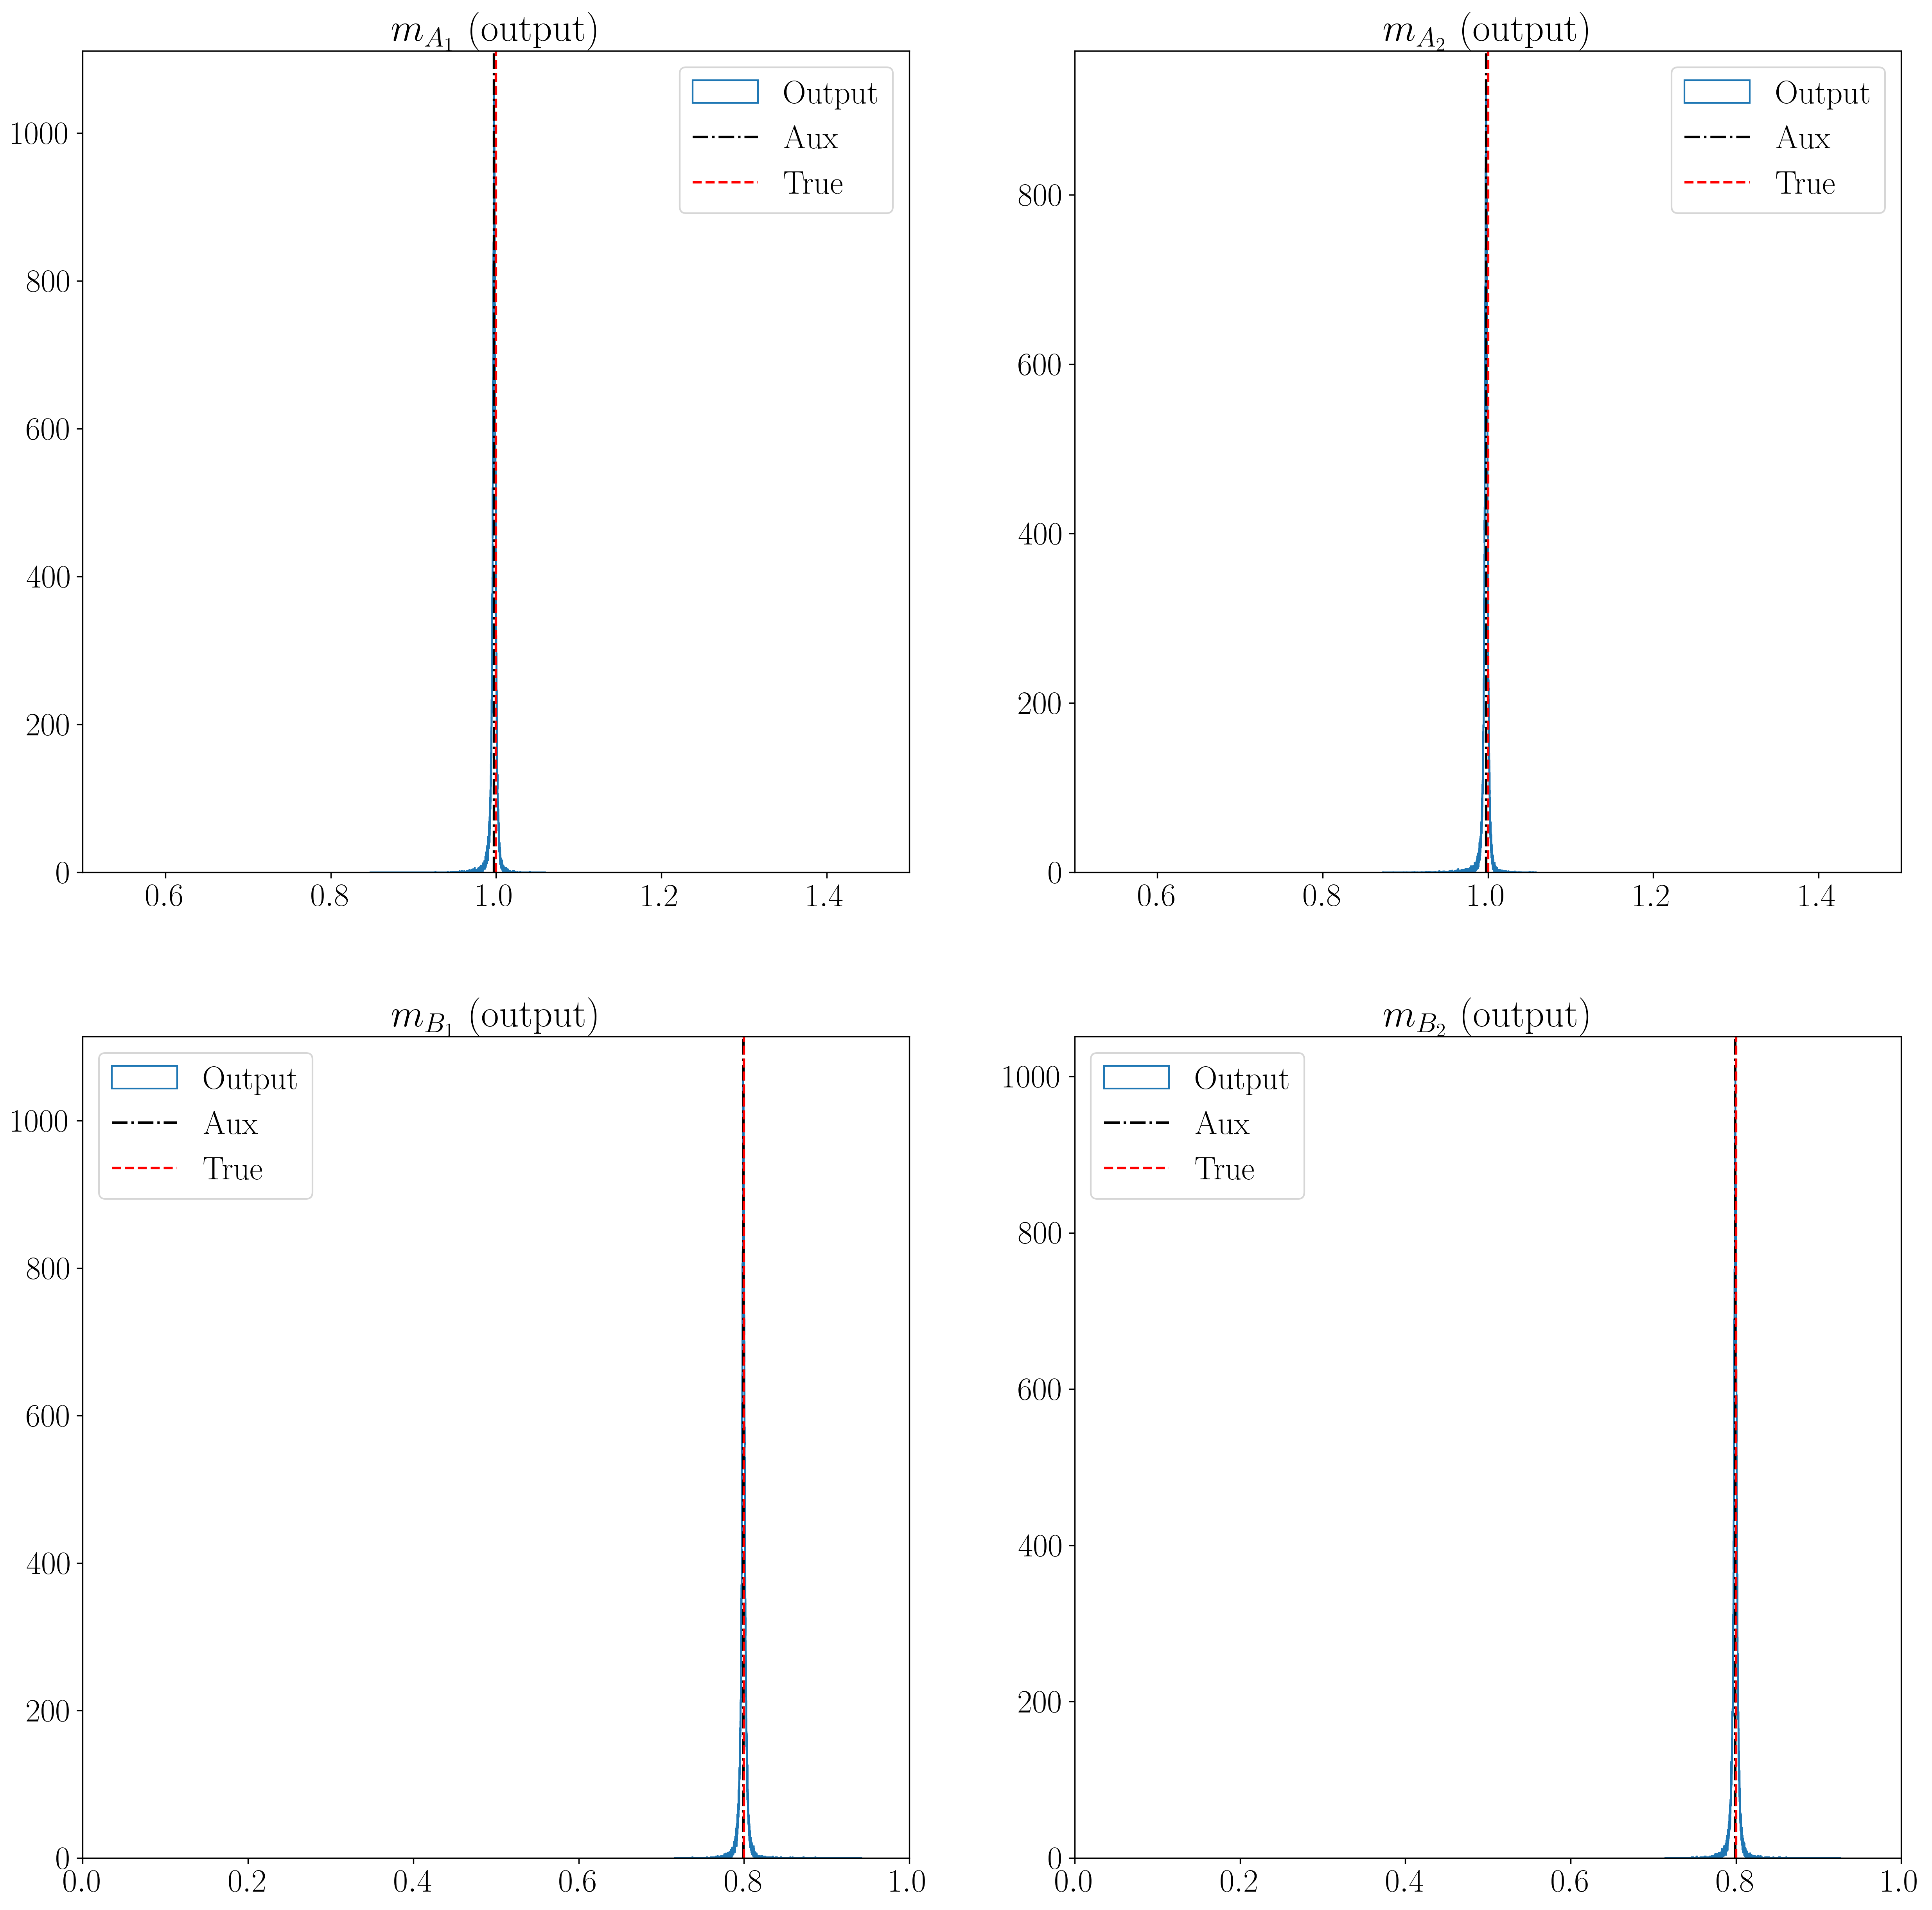

In [22]:
fig, axs = plt.subplots(2,2, figsize=(20, 20), dpi=300)
axs[0,0].hist(mA1_out, histtype='step', bins=10000, label='Output')
axs[0,0].axvline(m_A, color='black', linestyle='-.', label='Aux')
axs[0,0].axvline(1, color='red', linestyle='--', label='True')
axs[0,0].set_xlim(0.5, 1.5)
axs[0,0].set_title(r"$m_{A_1}$ (output)")
axs[0,0].legend()
axs[0,1].hist(mA2_out, histtype='step', bins=10000, label='Output')
axs[0,1].axvline(m_A, color='black', linestyle='-.', label='Aux')
axs[0,1].axvline(1, color='red', linestyle='--', label='True')
axs[0,1].set_xlim(0.5, 1.5)
axs[0,1].set_title(r"$m_{A_2}$ (output)")
axs[0,1].legend()
axs[1,0].hist(mB1_out, histtype='step', bins=10000, label='Output')
axs[1,0].axvline(m_B, color='black', linestyle='-.', label='Aux')
axs[1,0].axvline(0.8, color='red', linestyle='--', label='True')
axs[1,0].set_xlim(0, 1)
axs[1,0].set_title(r"$m_{B_1}$ (output)")
axs[1,0].legend()
axs[1,1].hist(mB2_out, histtype='step', bins=10000, label='Output')
axs[1,1].axvline(m_B, color='black', linestyle='-.', label='Aux')
axs[1,1].axvline(0.8, color='red', linestyle='--', label='True')
axs[1,1].set_xlim(0, 1)
axs[1,1].set_title(r"$m_{B_2}$ (output)")
axs[1,1].legend()
plt.savefig('01_DeeLeMa_Toy_masses.png')
plt.show()

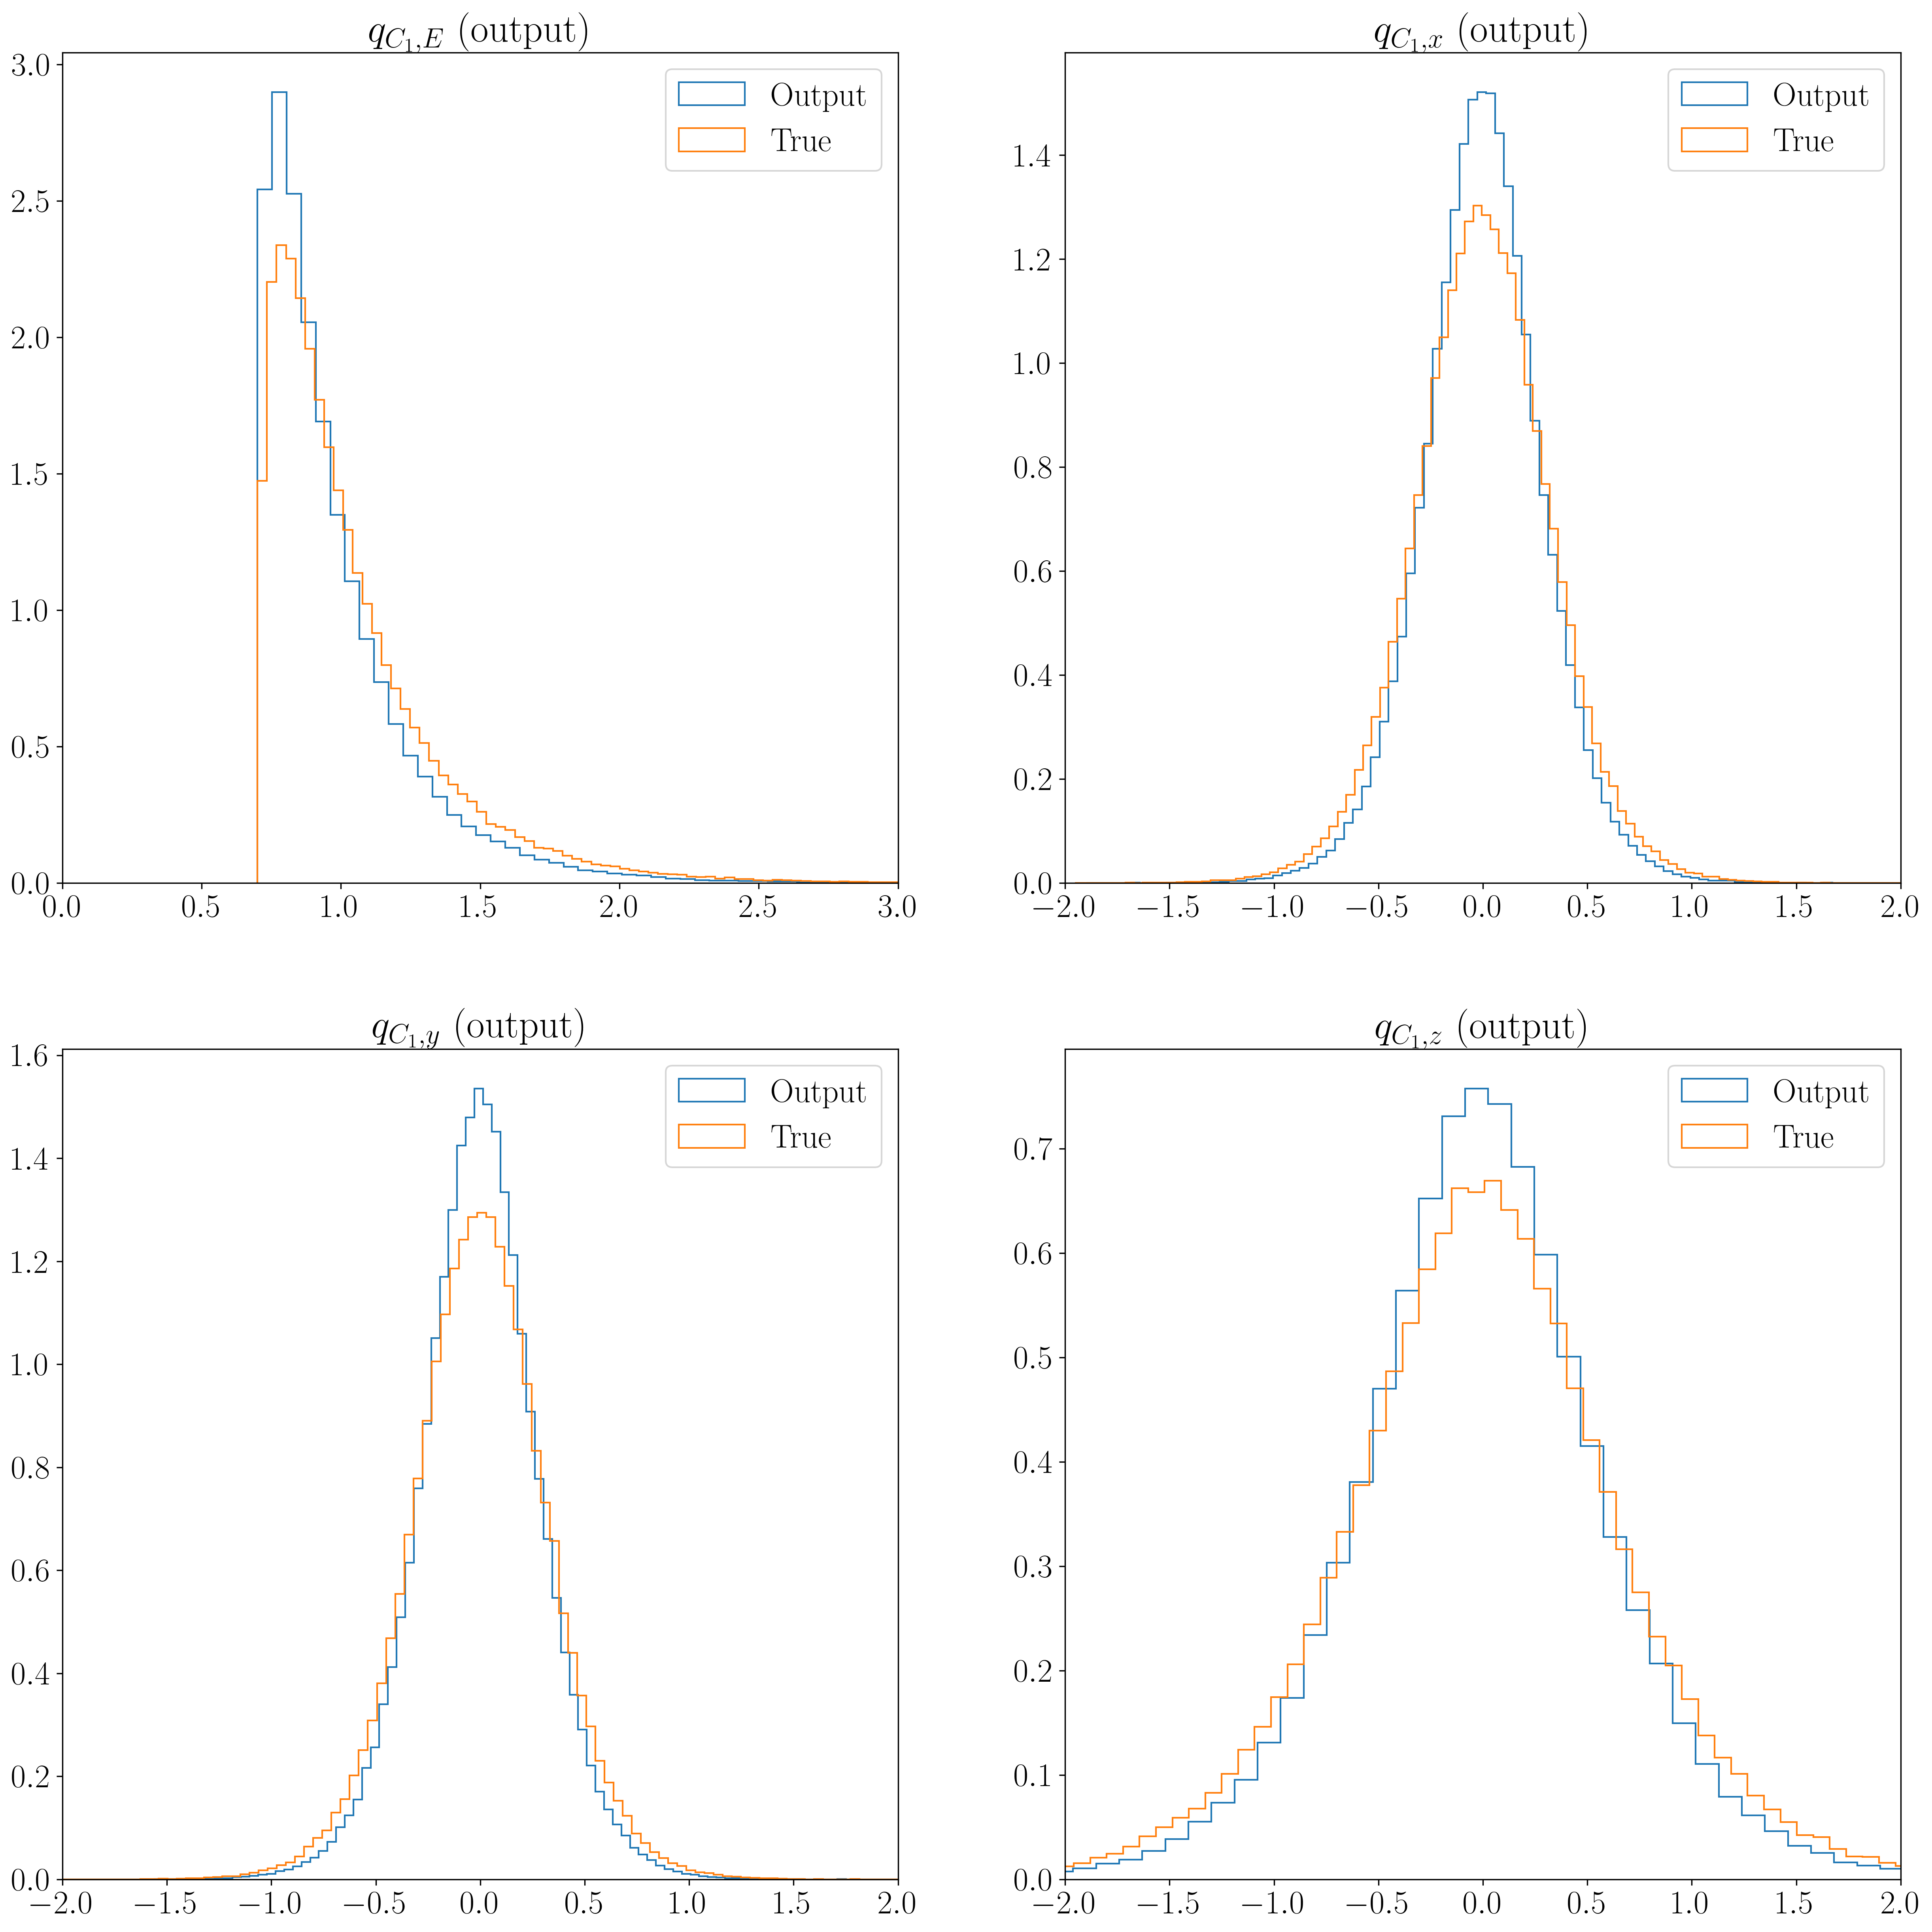

In [28]:
target_out = qc1_out
target_true = qc1
fig, axs = plt.subplots(2,2, figsize=(20, 20), dpi=300)
axs[0,0].hist(target_out[:,0], histtype='step', bins=100, density=True, label='Output')
axs[0,0].hist(target_true[:,0], histtype='step', density=True, bins=100, label='True')
axs[0,0].set_xlim(0, 3)
axs[0,0].set_title(r"$q_{C_1, E}$ (output)")
axs[0,0].legend()
axs[0,1].hist(target_out[:,1], histtype='step', bins=100, density=True, label='Output')
axs[0,1].hist(target_true[:,1], histtype='step', bins=100, density=True, label='True')
axs[0,1].set_xlim(-2, 2)
axs[0,1].set_title(r"$q_{C_1, x}$ (output)")
axs[0,1].legend()
axs[1,0].hist(target_out[:,2], histtype='step', bins=100, density=True, label='Output')
axs[1,0].hist(target_true[:,2], histtype='step', bins=100, density=True, label='True')
axs[1,0].set_xlim(-2, 2)
axs[1,0].set_title(r"$q_{C_1, y}$ (output)")
axs[1,0].legend()
axs[1,1].hist(target_out[:,3], histtype='step', bins=100, density=True, label='Output')
axs[1,1].hist(target_true[:,3], histtype='step', bins=100, density=True, label='True')
axs[1,1].set_xlim(-2, 2)
axs[1,1].set_title(r"$q_{C_1, z}$ (output)")
axs[1,1].legend()
plt.savefig("01_DeeLeMa_Toy_qC1.png")
plt.show()

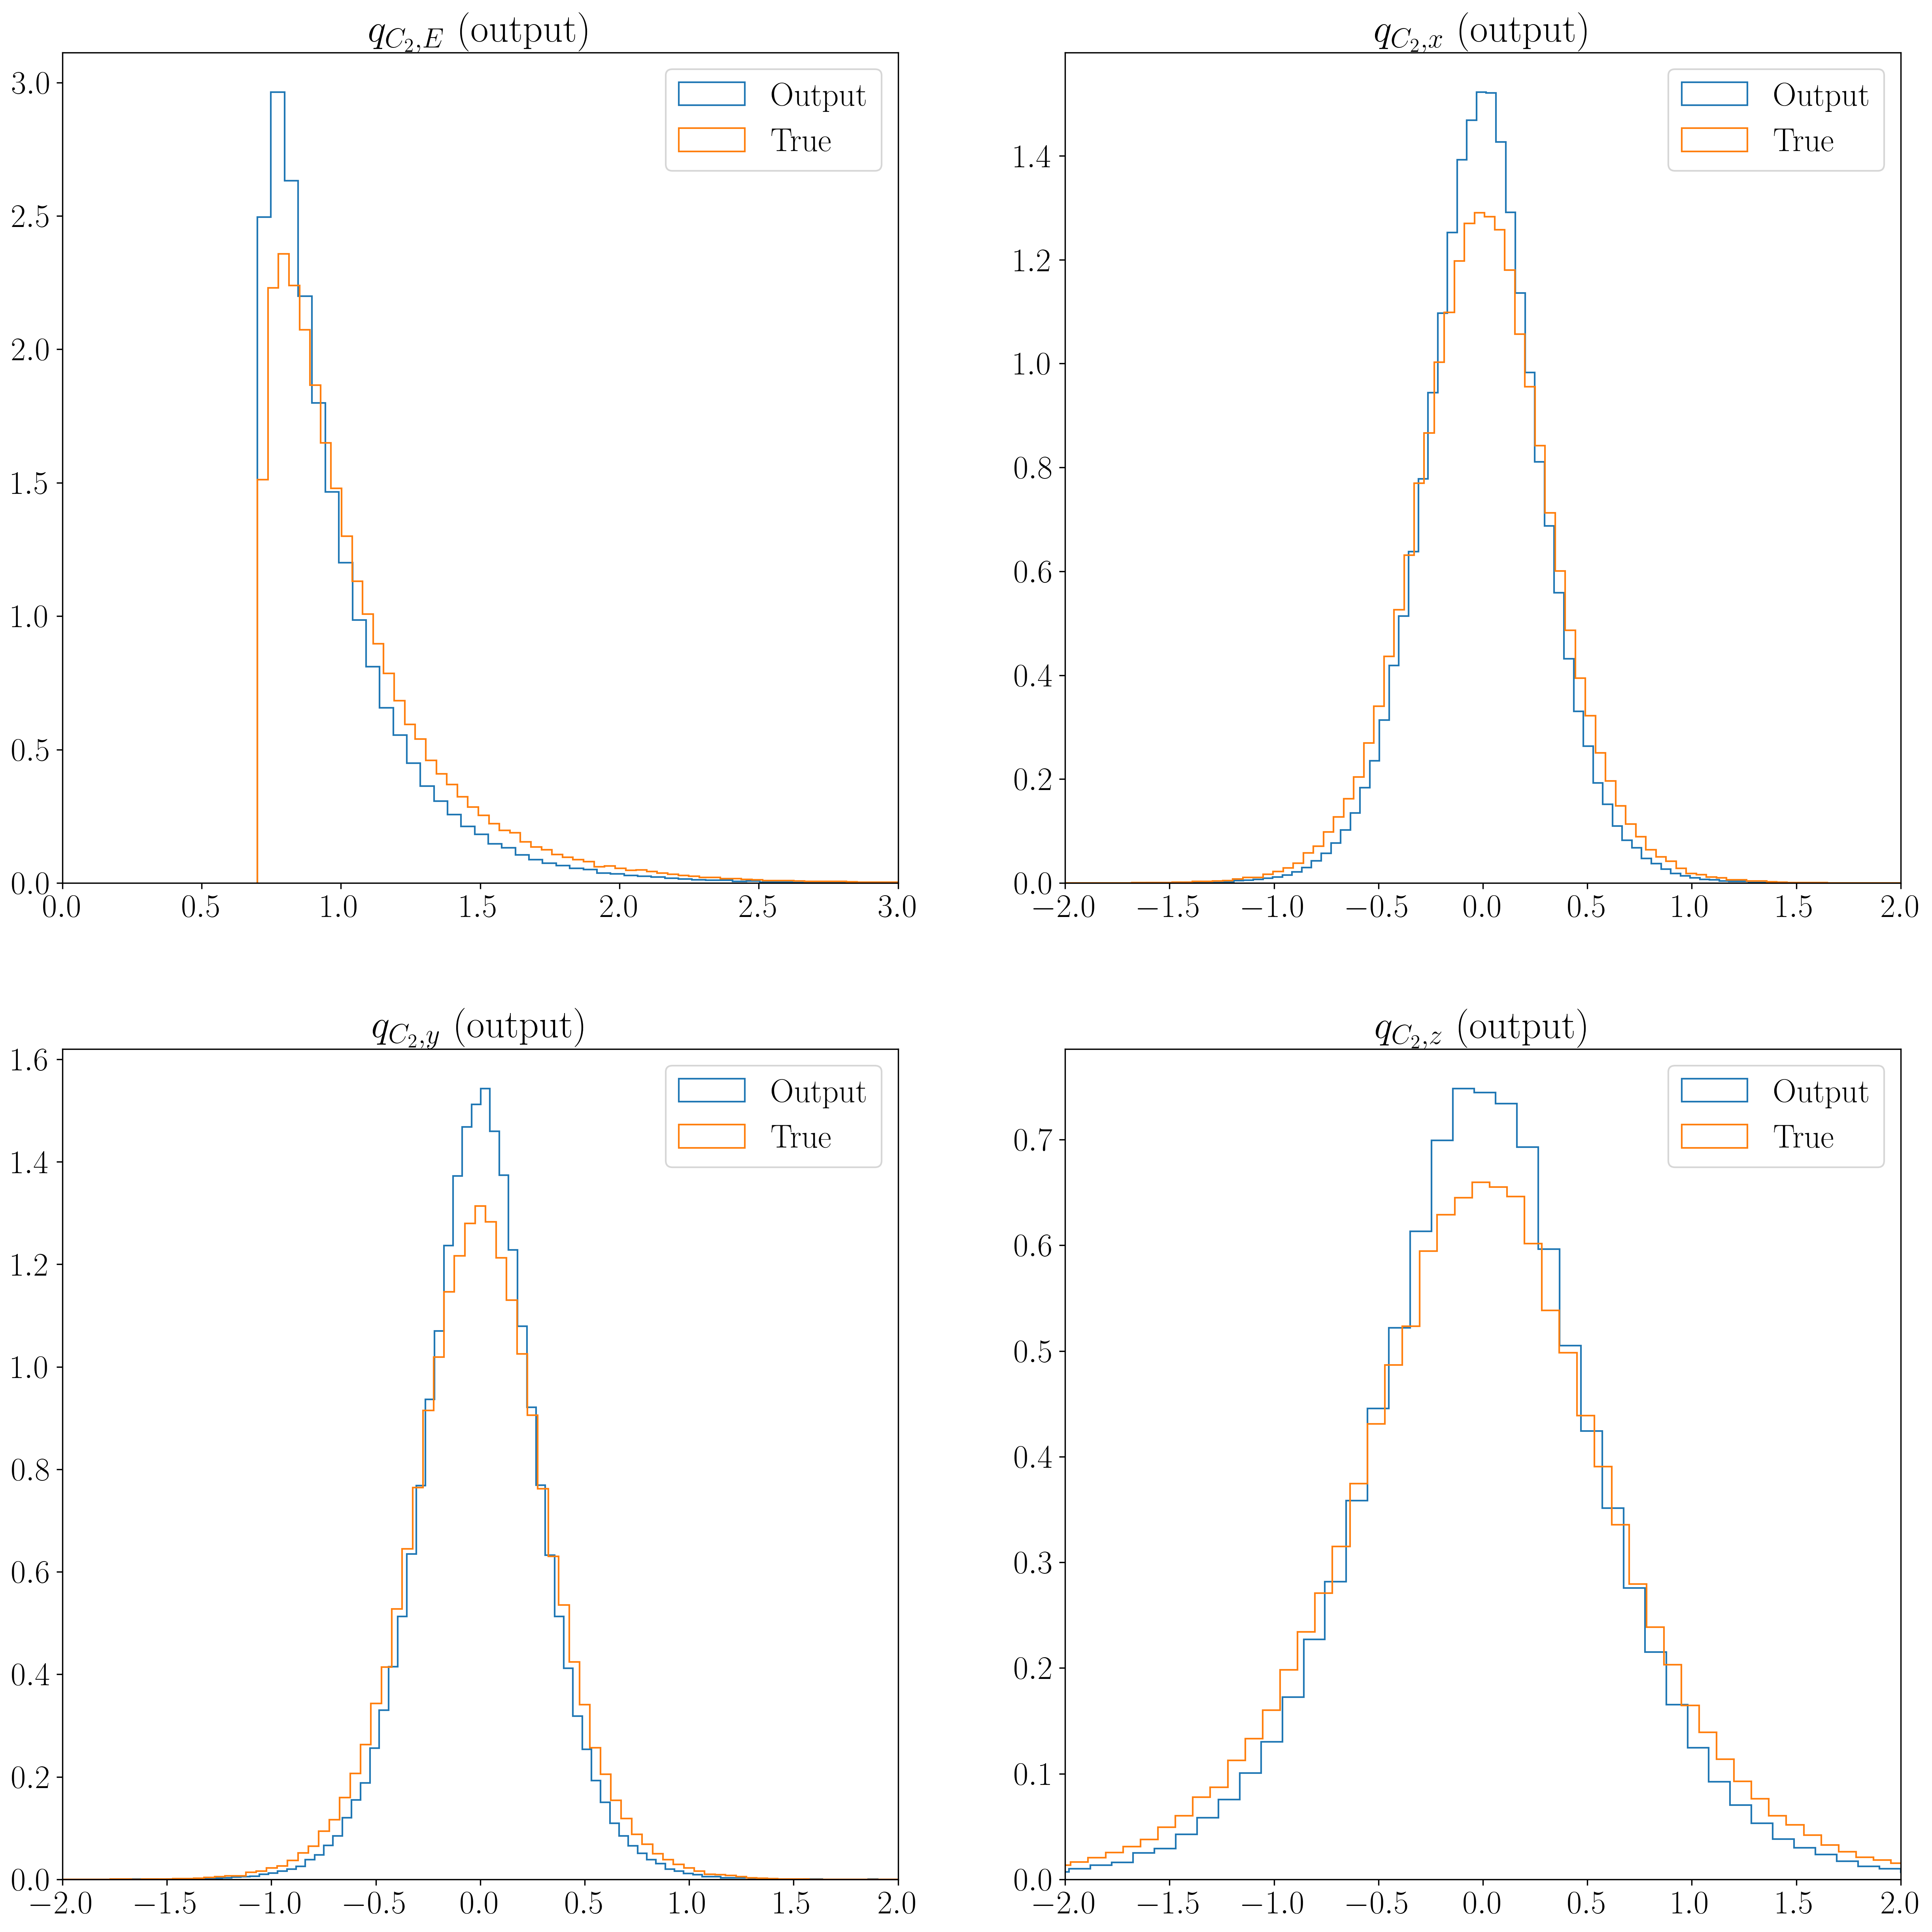

In [29]:
target_out = qc2_out
target_true = qc2
fig, axs = plt.subplots(2,2, figsize=(20, 20), dpi=300)
axs[0,0].hist(target_out[:,0], histtype='step', bins=100, density=True, label='Output')
axs[0,0].hist(target_true[:,0], histtype='step', density=True, bins=100, label='True')
axs[0,0].set_xlim(0, 3)
axs[0,0].set_title(r"$q_{C_2, E}$ (output)")
axs[0,0].legend()
axs[0,1].hist(target_out[:,1], histtype='step', bins=100, density=True, label='Output')
axs[0,1].hist(target_true[:,1], histtype='step', bins=100, density=True, label='True')
axs[0,1].set_xlim(-2, 2)
axs[0,1].set_title(r"$q_{C_2, x}$ (output)")
axs[0,1].legend()
axs[1,0].hist(target_out[:,2], histtype='step', bins=100, density=True, label='Output')
axs[1,0].hist(target_true[:,2], histtype='step', bins=100, density=True, label='True')
axs[1,0].set_xlim(-2, 2)
axs[1,0].set_title(r"$q_{C_2, y}$ (output)")
axs[1,0].legend()
axs[1,1].hist(target_out[:,3], histtype='step', bins=100, density=True, label='Output')
axs[1,1].hist(target_true[:,3], histtype='step', bins=100, density=True, label='True')
axs[1,1].set_xlim(-2, 2)
axs[1,1].set_title(r"$q_{C_2, z}$ (output)")
axs[1,1].legend()
plt.savefig("01_DeeLeMa_Toy_qC2.png")
plt.show()

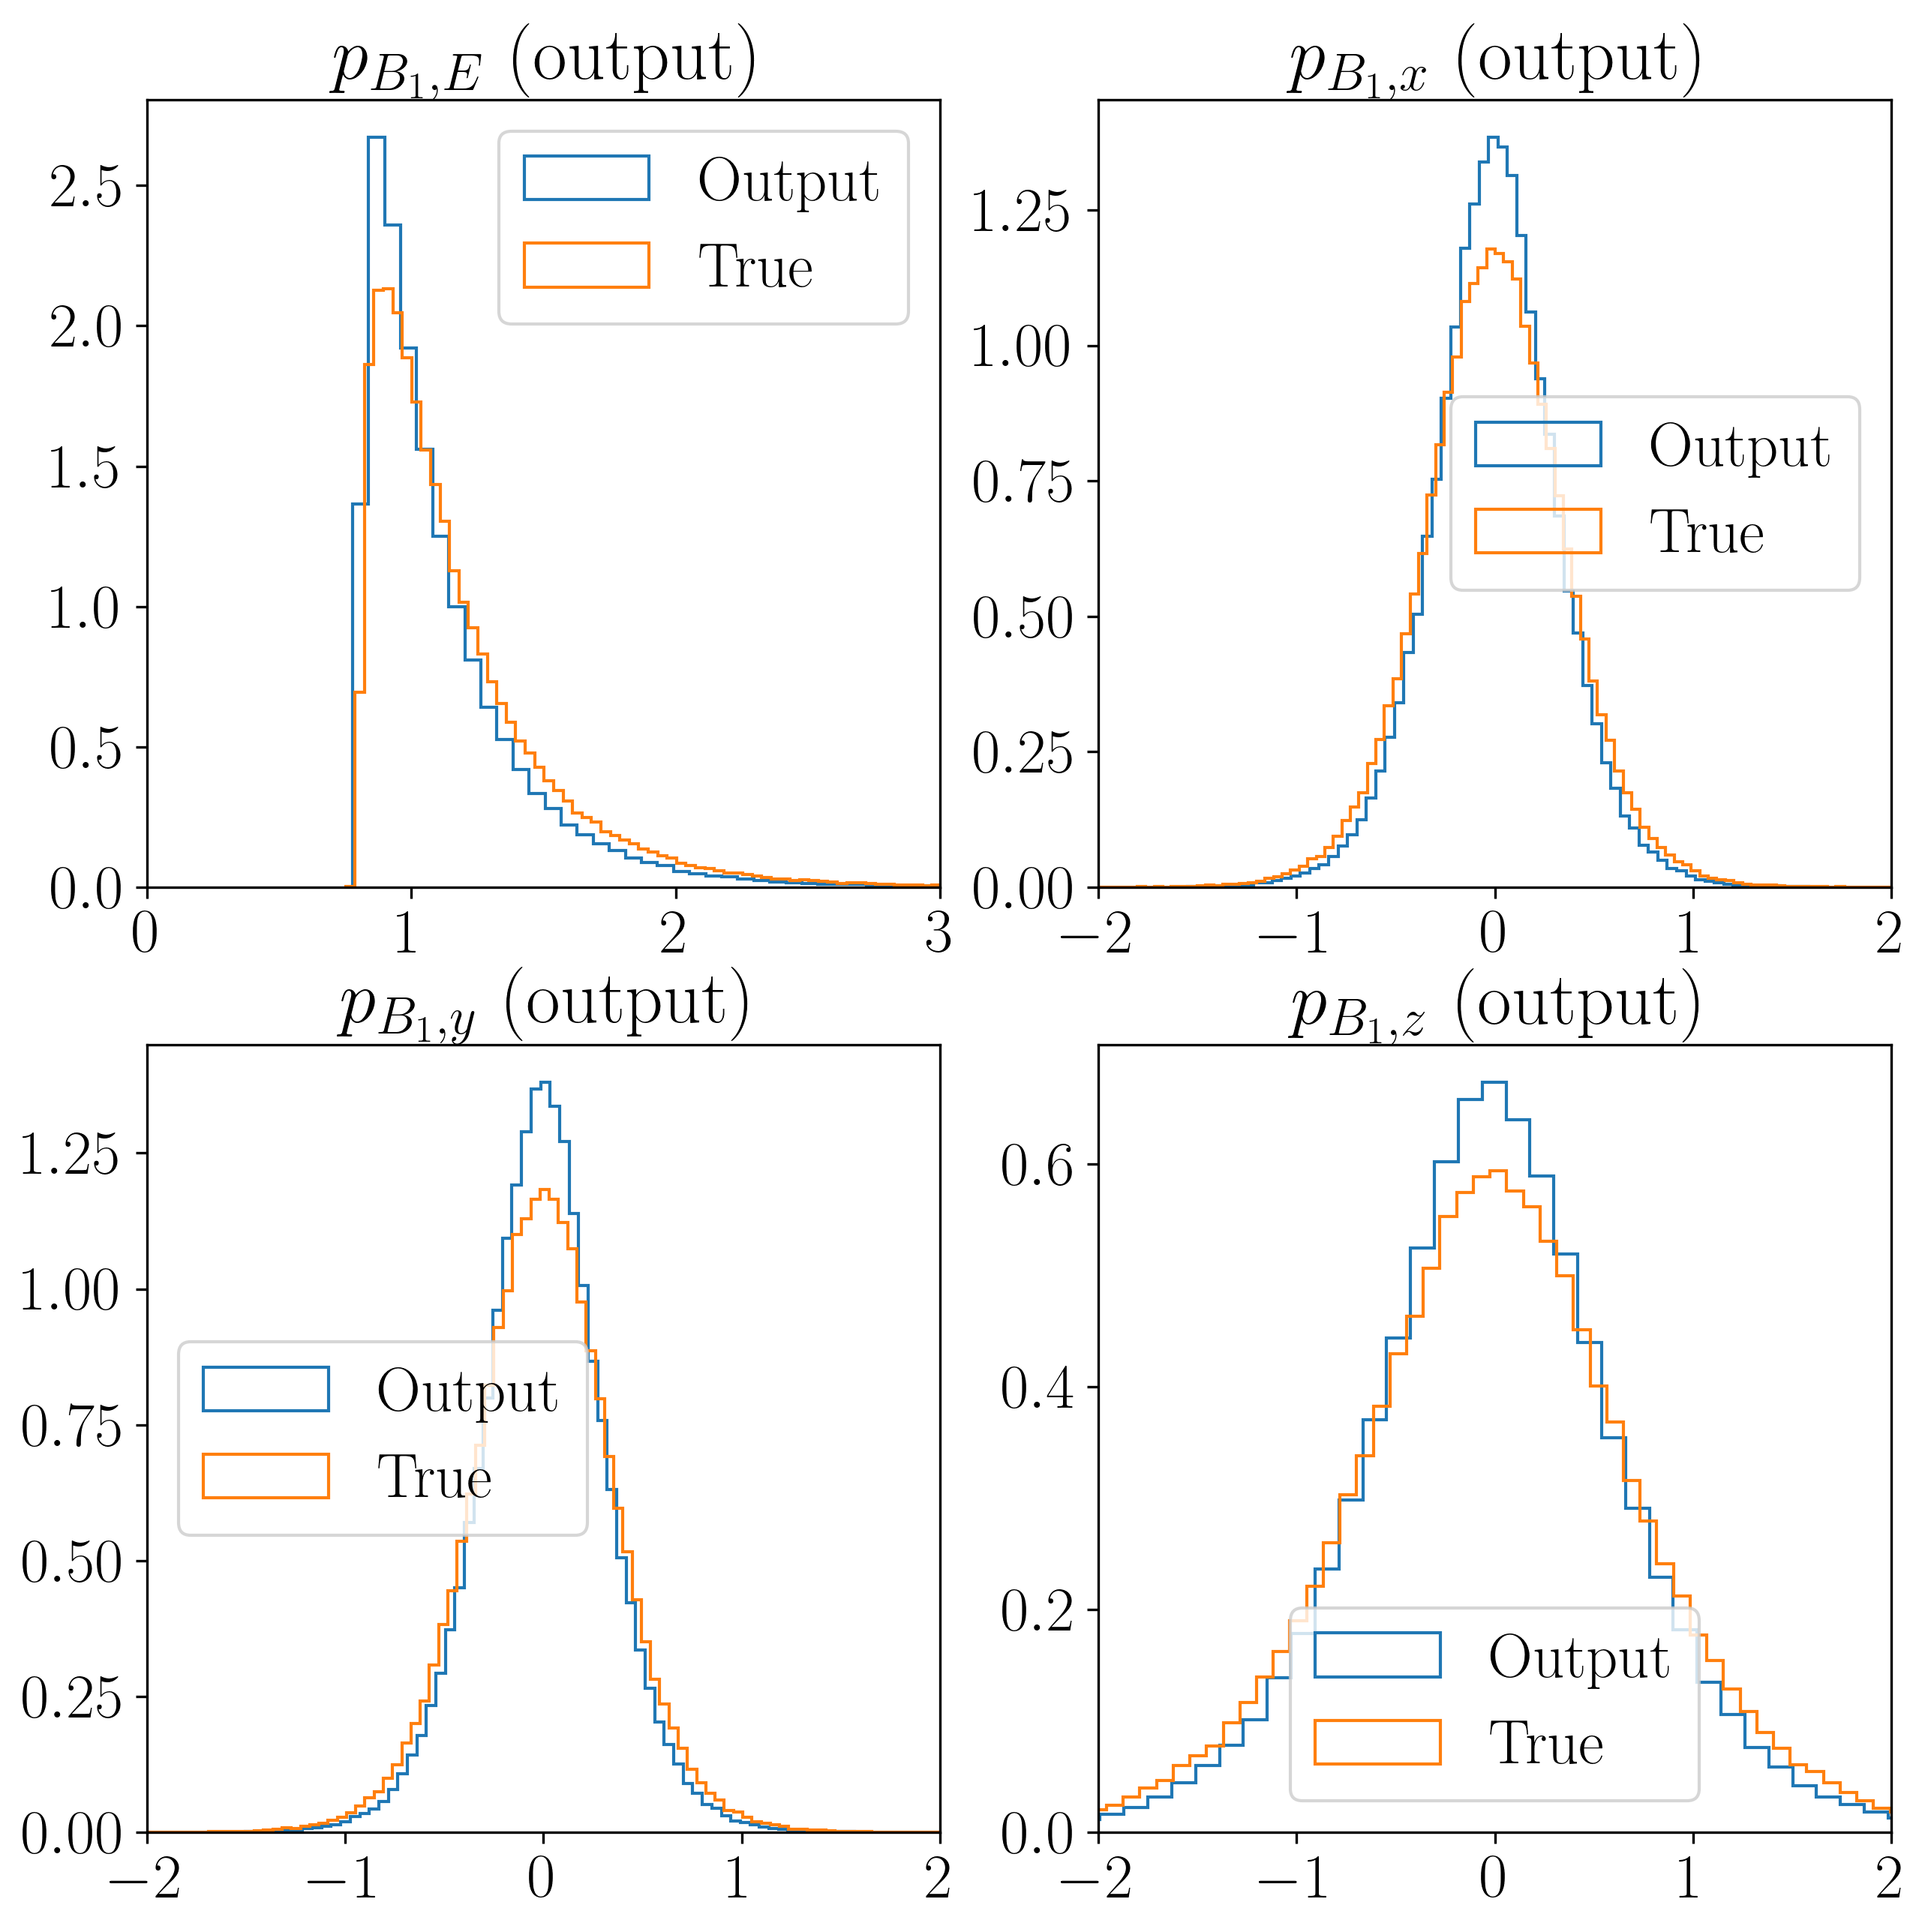

In [32]:
target_out = pB1_out
target_true = pB1
fig, axs = plt.subplots(2,2, figsize=(10, 10), dpi=300)
axs[0,0].hist(target_out[:,0], histtype='step', bins=100, density=True, label='Output')
axs[0,0].hist(target_true[:,0], histtype='step', density=True, bins=100, label='True')
axs[0,0].set_xlim(0, 3)
axs[0,0].set_title(r"$p_{B_1, E}$ (output)")
axs[0,0].legend()
axs[0,1].hist(target_out[:,1], histtype='step', bins=100, density=True, label='Output')
axs[0,1].hist(target_true[:,1], histtype='step', bins=100, density=True, label='True')
axs[0,1].set_xlim(-2, 2)
axs[0,1].set_title(r"$p_{B_1, x}$ (output)")
axs[0,1].legend()
axs[1,0].hist(target_out[:,2], histtype='step', bins=100, density=True, label='Output')
axs[1,0].hist(target_true[:,2], histtype='step', bins=100, density=True, label='True')
axs[1,0].set_xlim(-2, 2)
axs[1,0].set_title(r"$p_{B_1, y}$ (output)")
axs[1,0].legend()
axs[1,1].hist(target_out[:,3], histtype='step', bins=100, density=True, label='Output')
axs[1,1].hist(target_true[:,3], histtype='step', bins=100, density=True, label='True')
axs[1,1].set_xlim(-2, 2)
axs[1,1].set_title(r"$p_{B_1, z}$ (output)")
axs[1,1].legend()
plt.savefig("01_DeeLeMa_Toy_pB1.png")
plt.show()

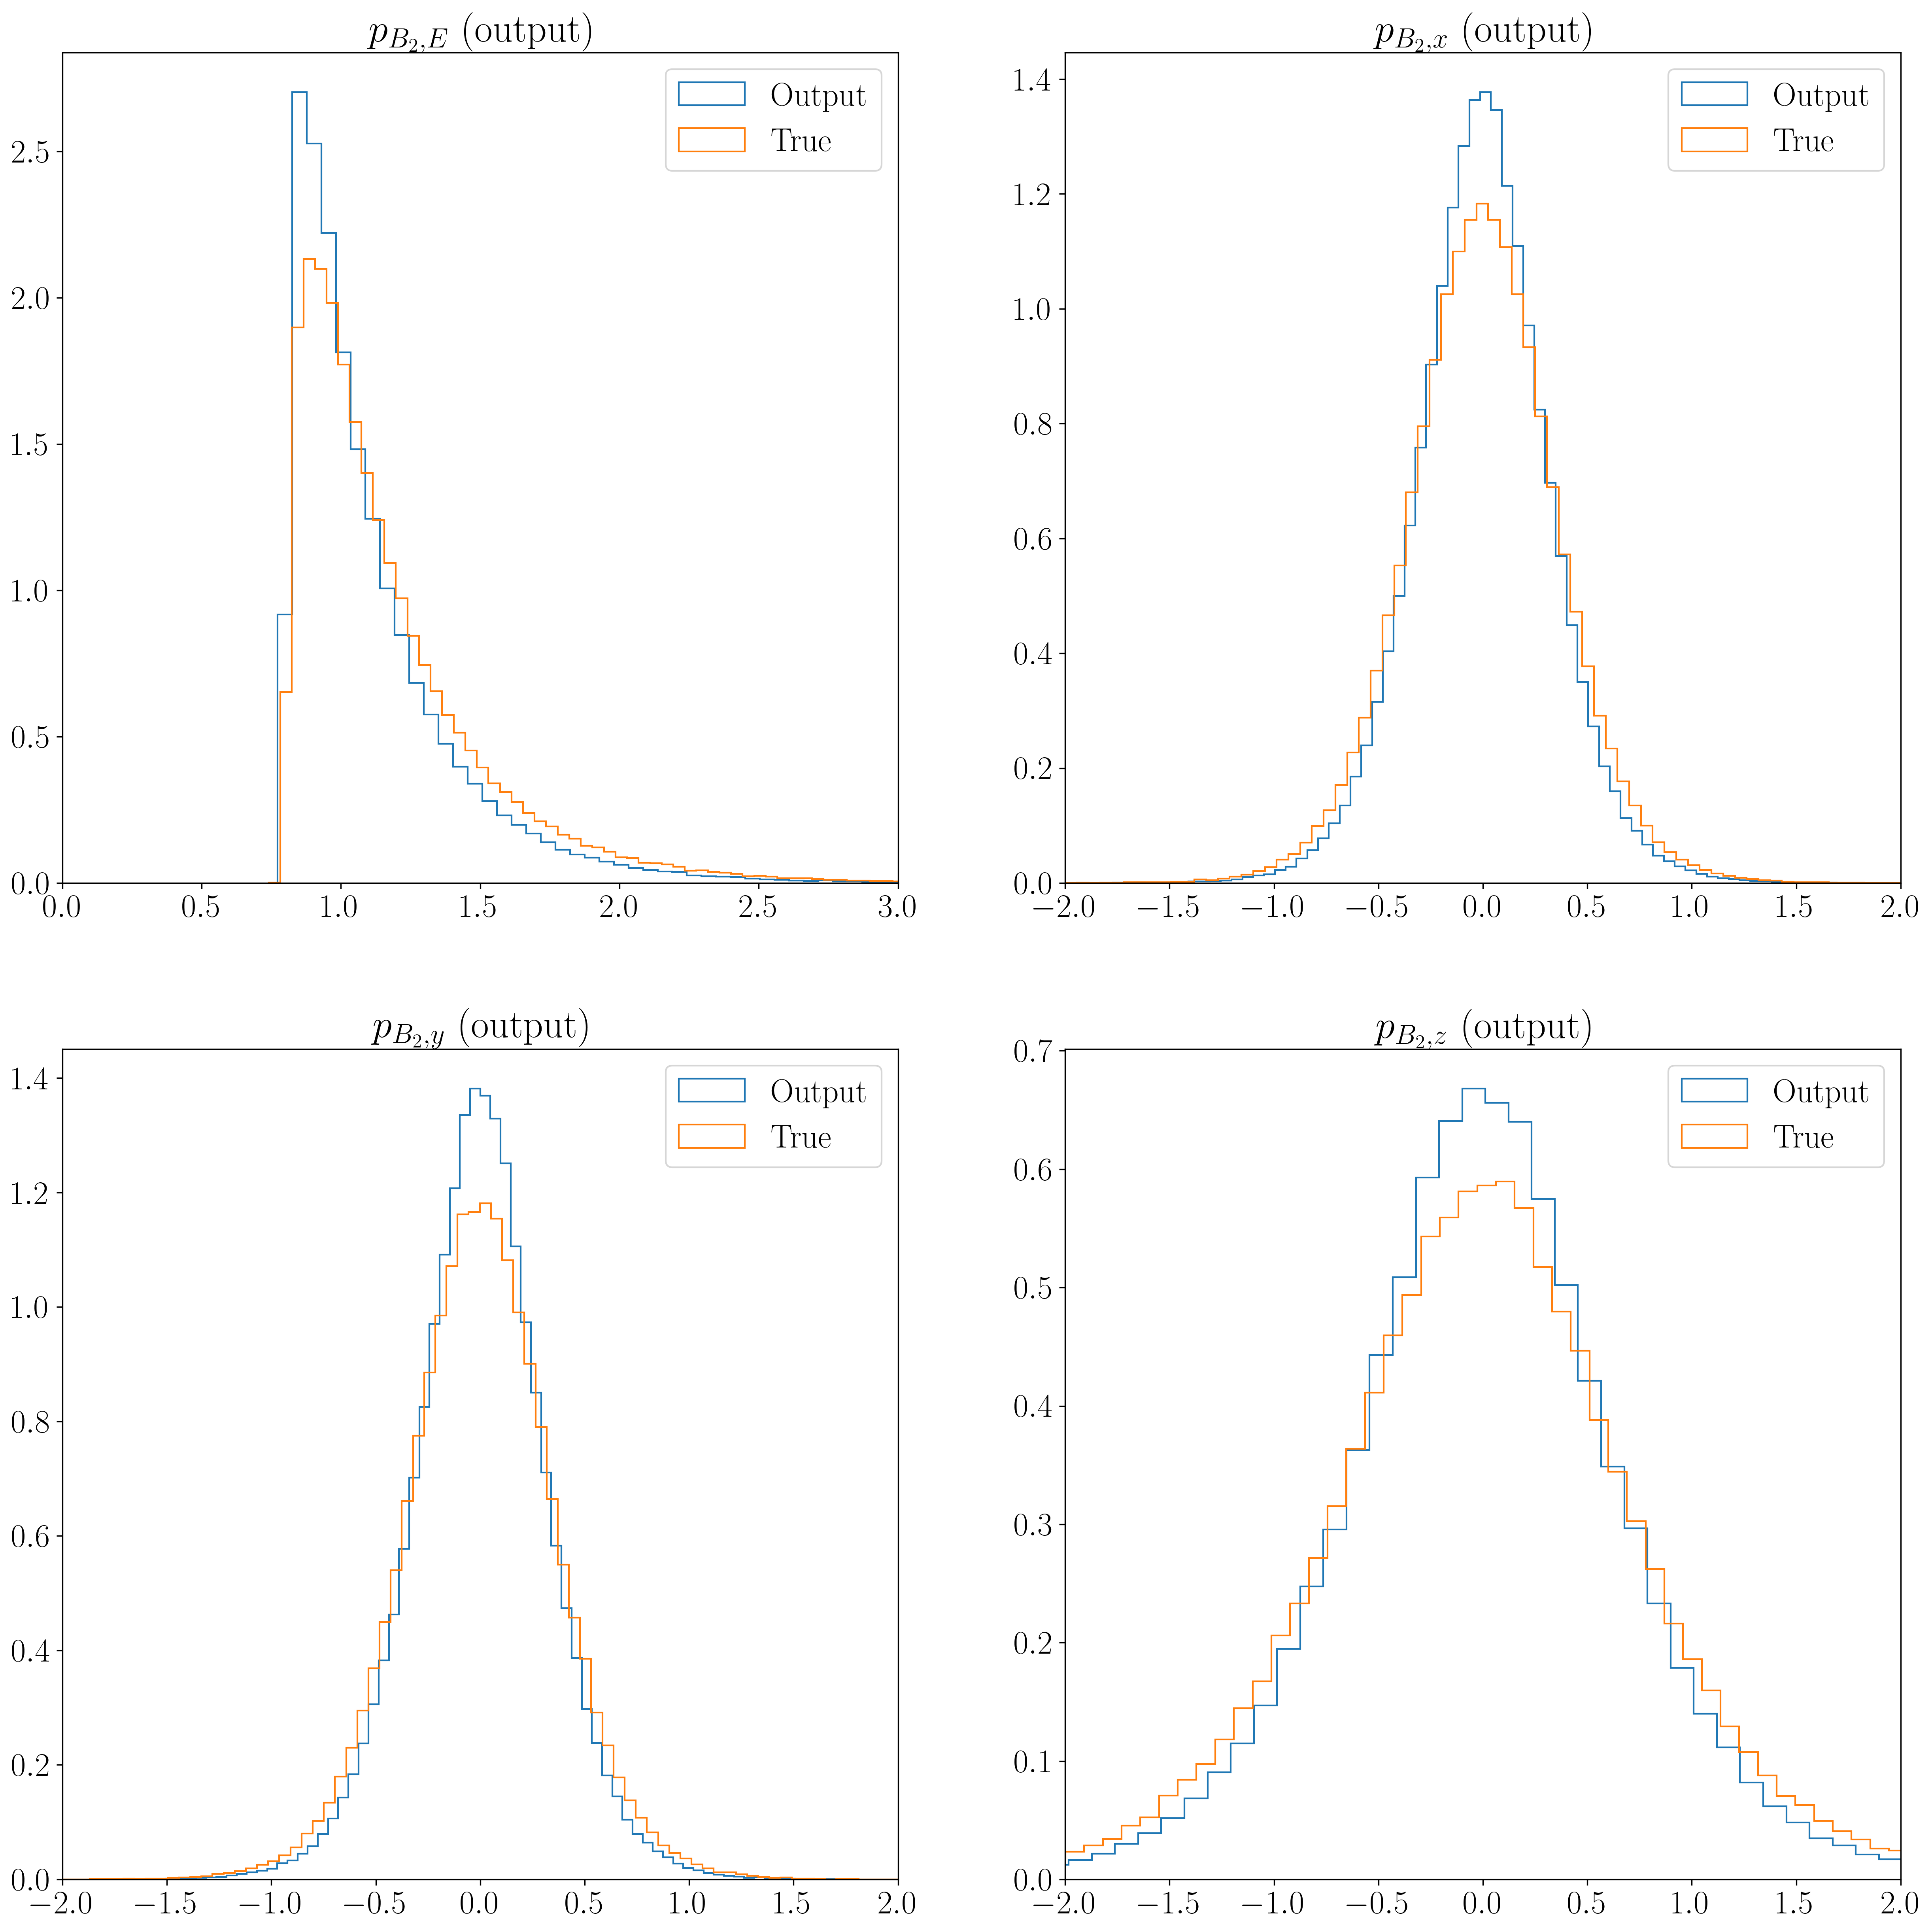

In [33]:
target_out = pB2_out
target_true = pB2
fig, axs = plt.subplots(2,2, figsize=(20, 20), dpi=300)
axs[0,0].hist(target_out[:,0], histtype='step', bins=100, density=True, label='Output')
axs[0,0].hist(target_true[:,0], histtype='step', density=True, bins=100, label='True')
axs[0,0].set_xlim(0, 3)
axs[0,0].set_title(r"$p_{B_2, E}$ (output)")
axs[0,0].legend()
axs[0,1].hist(target_out[:,1], histtype='step', bins=100, density=True, label='Output')
axs[0,1].hist(target_true[:,1], histtype='step', bins=100, density=True, label='True')
axs[0,1].set_xlim(-2, 2)
axs[0,1].set_title(r"$p_{B_2, x}$ (output)")
axs[0,1].legend()
axs[1,0].hist(target_out[:,2], histtype='step', bins=100, density=True, label='Output')
axs[1,0].hist(target_true[:,2], histtype='step', bins=100, density=True, label='True')
axs[1,0].set_xlim(-2, 2)
axs[1,0].set_title(r"$p_{B_2, y}$ (output)")
axs[1,0].legend()
axs[1,1].hist(target_out[:,3], histtype='step', bins=100, density=True, label='Output')
axs[1,1].hist(target_true[:,3], histtype='step', bins=100, density=True, label='True')
axs[1,1].set_xlim(-2, 2)
axs[1,1].set_title(r"$p_{B_2, z}$ (output)")
axs[1,1].legend()
plt.savefig("01_DeeLeMa_Toy_pB2.png")
plt.show()

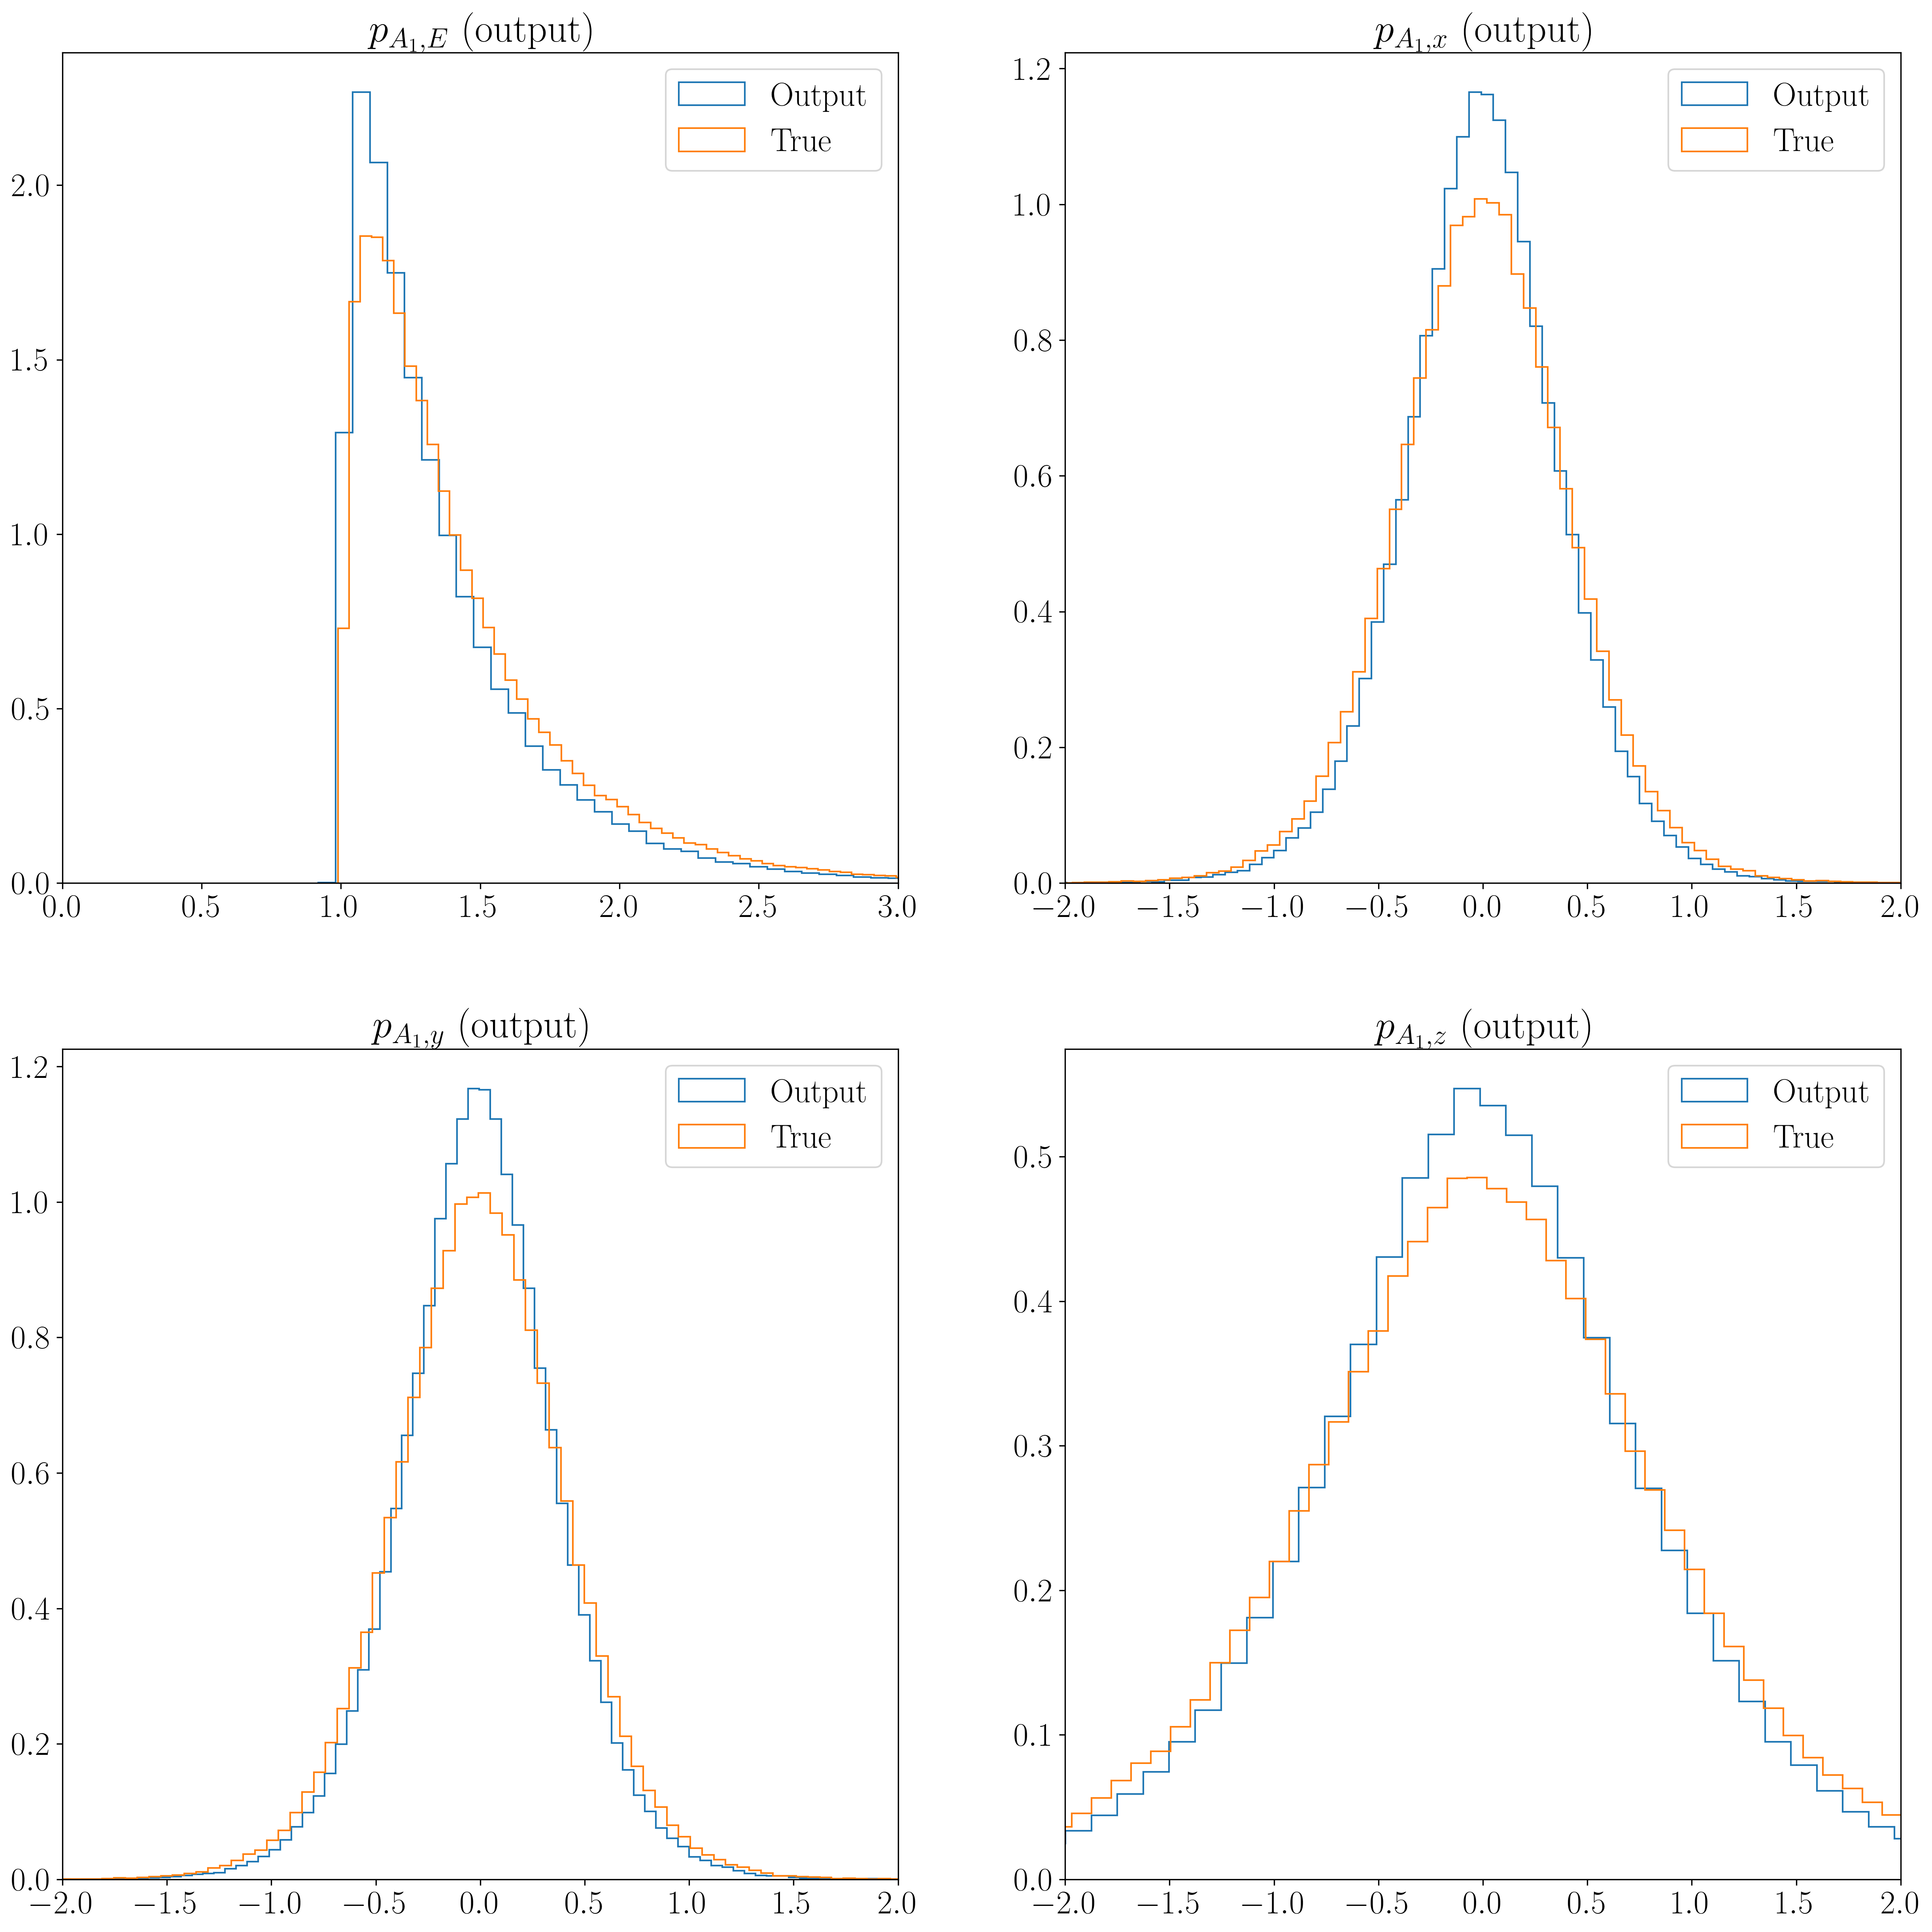

In [34]:
target_out = pA1_out
target_true = pA1
fig, axs = plt.subplots(2,2, figsize=(20, 20), dpi=300)
axs[0,0].hist(target_out[:,0], histtype='step', bins=100, density=True, label='Output')
axs[0,0].hist(target_true[:,0], histtype='step', density=True, bins=100, label='True')
axs[0,0].set_xlim(0, 3)
axs[0,0].set_title(r"$p_{A_1, E}$ (output)")
axs[0,0].legend()
axs[0,1].hist(target_out[:,1], histtype='step', bins=100, density=True, label='Output')
axs[0,1].hist(target_true[:,1], histtype='step', bins=100, density=True, label='True')
axs[0,1].set_xlim(-2, 2)
axs[0,1].set_title(r"$p_{A_1, x}$ (output)")
axs[0,1].legend()
axs[1,0].hist(target_out[:,2], histtype='step', bins=100, density=True, label='Output')
axs[1,0].hist(target_true[:,2], histtype='step', bins=100, density=True, label='True')
axs[1,0].set_xlim(-2, 2)
axs[1,0].set_title(r"$p_{A_1, y}$ (output)")
axs[1,0].legend()
axs[1,1].hist(target_out[:,3], histtype='step', bins=100, density=True, label='Output')
axs[1,1].hist(target_true[:,3], histtype='step', bins=100, density=True, label='True')
axs[1,1].set_xlim(-2, 2)
axs[1,1].set_title(r"$p_{A_1, z}$ (output)")
axs[1,1].legend()
plt.savefig("01_DeeLeMa_Toy_pA1.png")
plt.show()

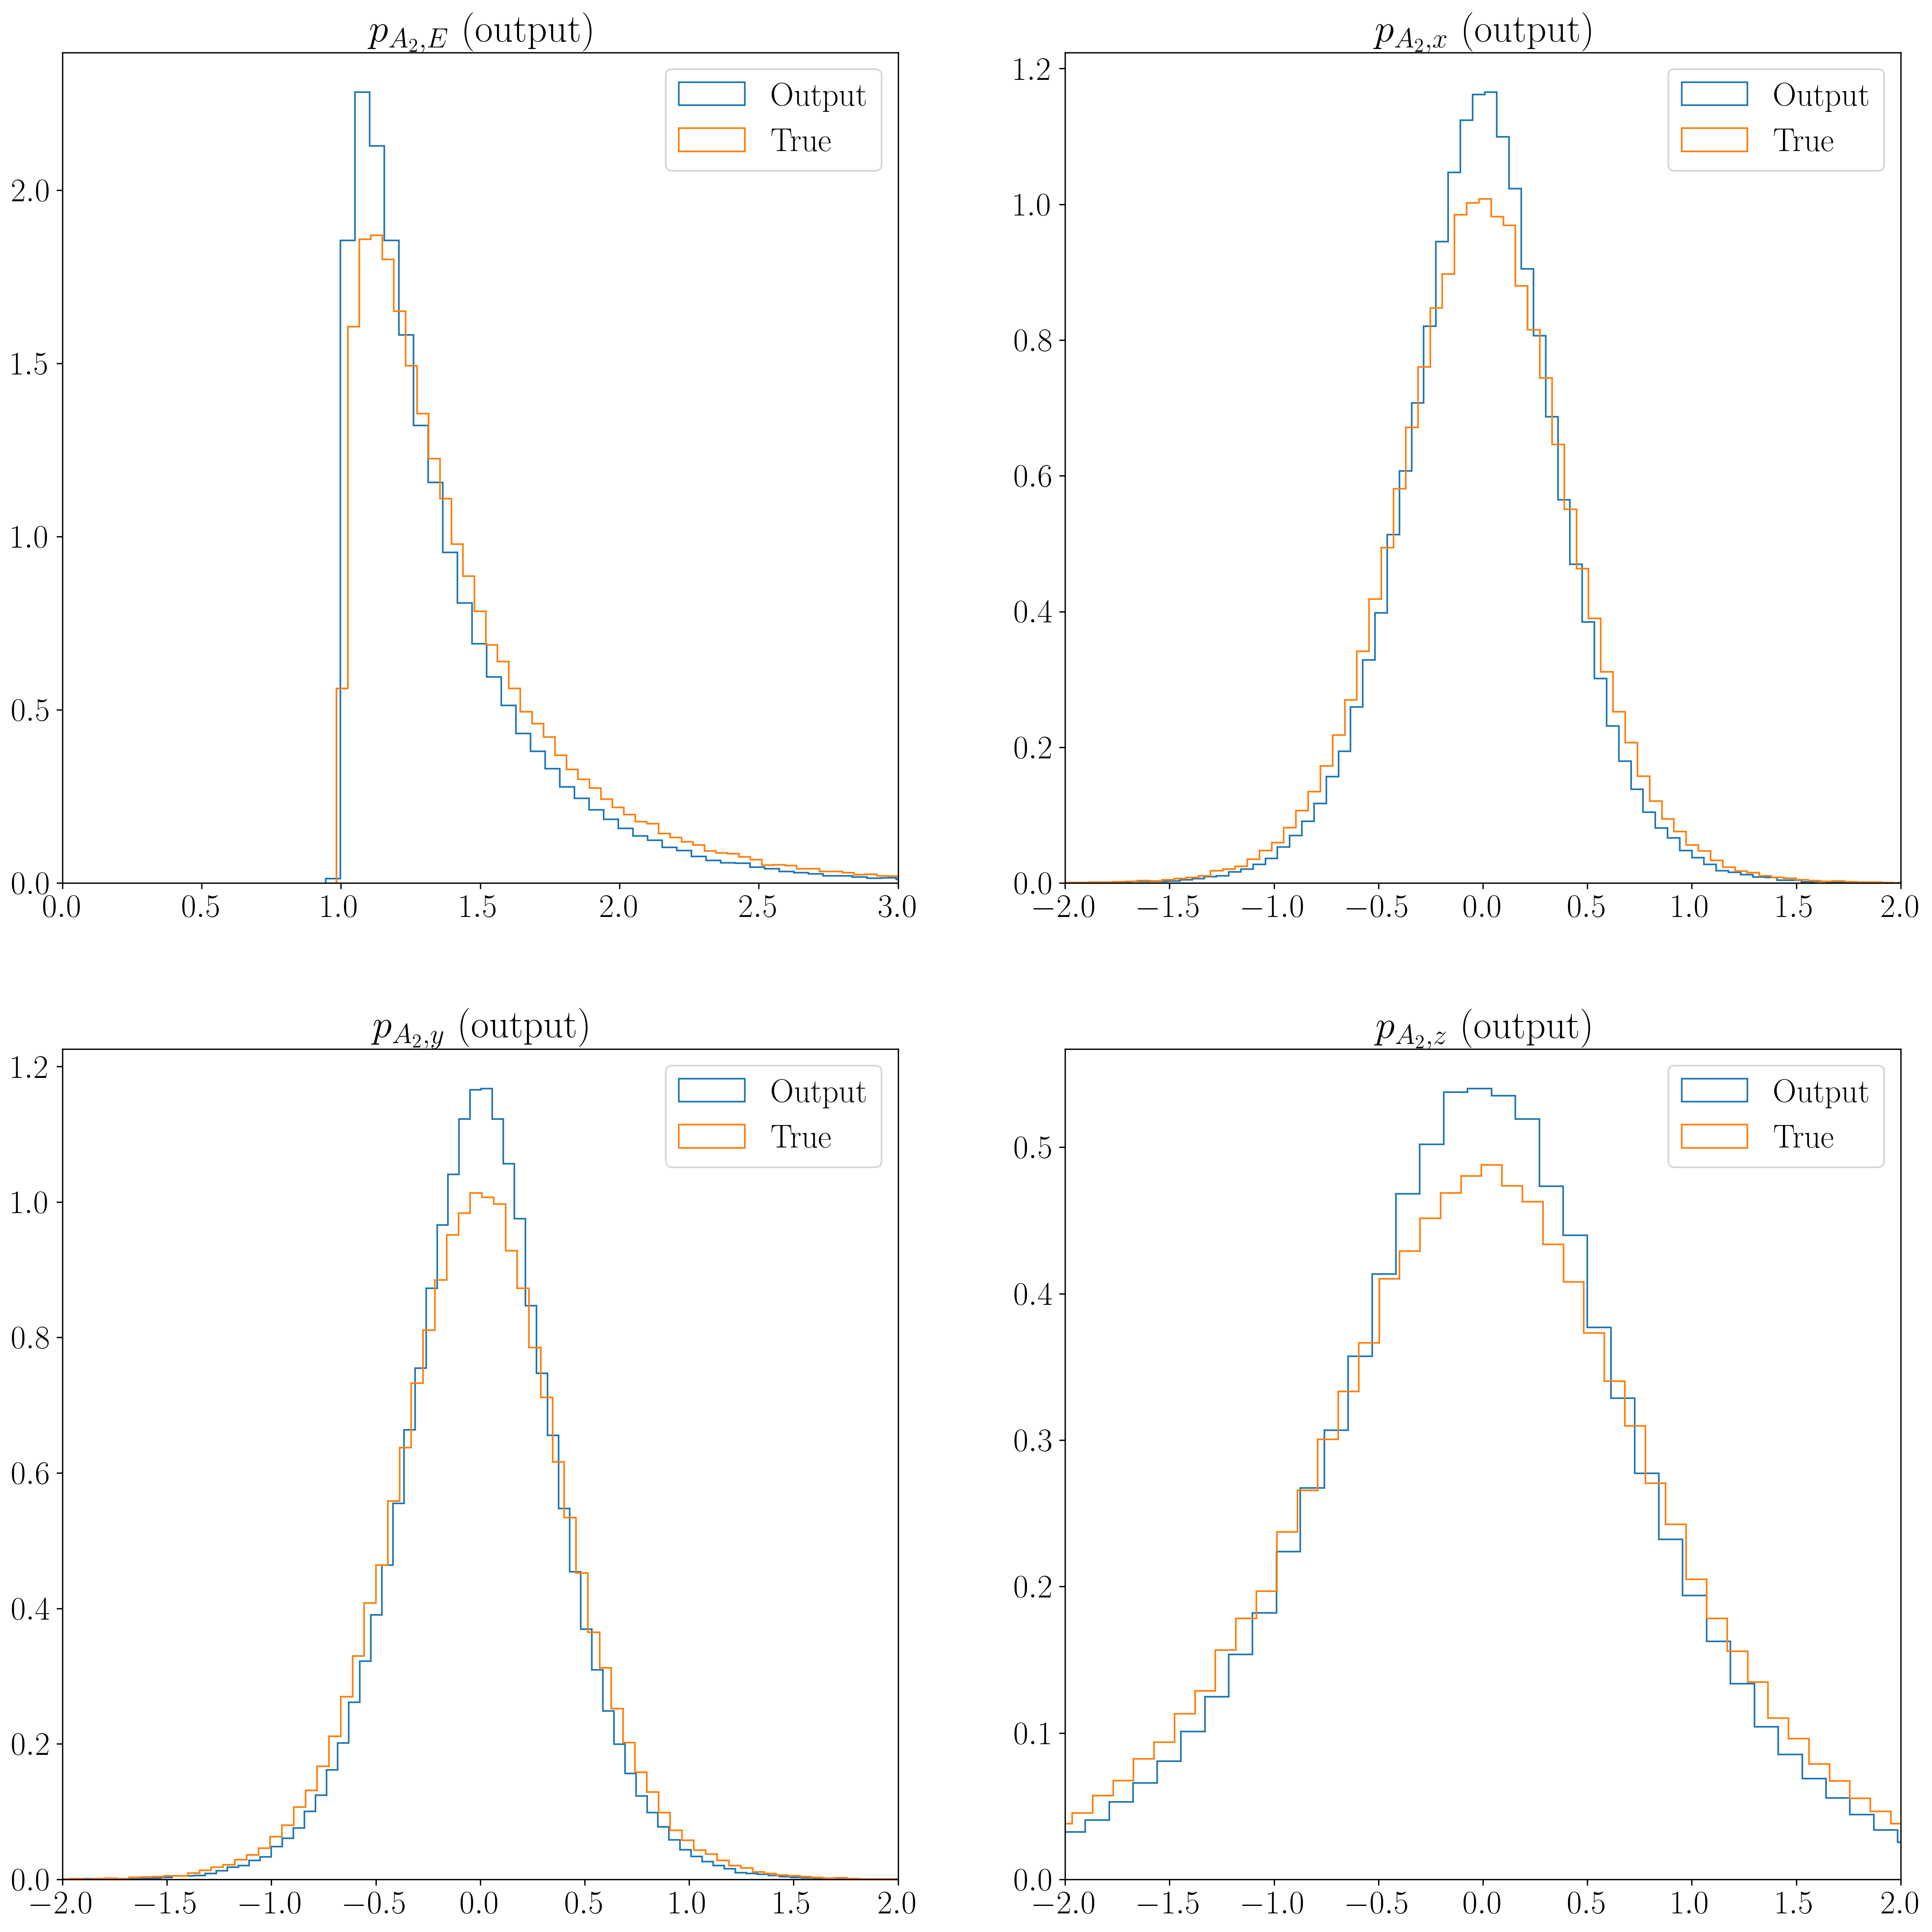

In [35]:
target_out = pA2_out
target_true = pA2
fig, axs = plt.subplots(2,2, figsize=(20, 20), dpi=300)
axs[0,0].hist(target_out[:,0], histtype='step', bins=100, density=True, label='Output')
axs[0,0].hist(target_true[:,0], histtype='step', density=True, bins=100, label='True')
axs[0,0].set_xlim(0, 3)
axs[0,0].set_title(r"$p_{A_2, E}$ (output)")
axs[0,0].legend()
axs[0,1].hist(target_out[:,1], histtype='step', bins=100, density=True, label='Output')
axs[0,1].hist(target_true[:,1], histtype='step', bins=100, density=True, label='True')
axs[0,1].set_xlim(-2, 2)
axs[0,1].set_title(r"$p_{A_2, x}$ (output)")
axs[0,1].legend()
axs[1,0].hist(target_out[:,2], histtype='step', bins=100, density=True, label='Output')
axs[1,0].hist(target_true[:,2], histtype='step', bins=100, density=True, label='True')
axs[1,0].set_xlim(-2, 2)
axs[1,0].set_title(r"$p_{A_2, y}$ (output)")
axs[1,0].legend()
axs[1,1].hist(target_out[:,3], histtype='step', bins=100, density=True, label='Output')
axs[1,1].hist(target_true[:,3], histtype='step', bins=100, density=True, label='True')
axs[1,1].set_xlim(-2, 2)
axs[1,1].set_title(r"$p_{A_2, z}$ (output)")
axs[1,1].legend()
plt.savefig("01_DeeLeMa_Toy_pA2.png")
plt.show()
